In [1]:
import os
import pandas as pd
import numpy as np
import bz2
import json
import time
from datetime import datetime, date, timedelta
import pickle
import glob
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.signal import find_peaks
from scipy.stats import pearsonr
import statsmodels.api as sm
import statsmodels.formula.api as smf

#NLP libraries
import spacy, nltk

#Vader
import vaderSentiment
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer

In [301]:
p = 'total-data-merged.pkl.bz2'
total_df = pd.read_pickle(p,compression='bz2')

In [310]:
total_df.head()

,quotation,speaker,qids,date,numOccurrences,domains,speaker_probability,date_of_birth,nationality,gender,ethnic_group,occupation,party,academic_degree,label,religion,age,age_bracket
quoteID,,,,,,,,,,,,,,,,,,
2015-06-02-000948,"However, in the meantime compulsory encryption...",Chris McIntosh,Q5107420,2015-06-02,1,[computerweekly],0.8306,1977-02-20,United States of America,male,None,American football player,None,None,Chris McIntosh,None,38.0,[36-60]
2015-09-20-001335,A missile landed on the house of Abdul Waheed ...,Zahid Khan,Q24005455,2015-09-20,1,[tribune],0.8935,1976-01-01,None,male,None,cricketer,None,None,Zahid Khan,None,39.0,[36-60]
2015-10-21-003064,a remarkable demonstration of chutzpah.,Ben Bernanke,Q201795,2015-10-21,1,[washingtonpost],0.7873,1953-12-13,United States of America,male,Jewish people,"[economist, politician, professor, banker]",Republican,None,Ben Bernanke,Judaism,61.0,[60+]
2015-01-06-021216,I couldn't help but think of the disrespect th...,Michael Harrison,Q17414590,2015-01-06,1,[fox8live],0.6762,NaT,None,male,None,radio personality,None,None,Michael Harrison,None,NaN,NaN
2015-05-29-001442,"according to David Lynch, I WILL be involved i...",Sheryl Lee,Q233593,2015-05-29,2,"[express, express]",0.5384,1967-04-22,United States of America,female,None,"[actor, stage actor, television actor, film ac...",None,None,Sheryl Lee,None,48.0,[36-60]


### Computing the age and adding it to the dataframe

In [12]:
def get_age(date_of_birth, date_of_quotation):
  '''Calculate the age of the speaker at the date of the quote.'''
  # if the person was born after the quotation
  if date_of_birth > date_of_quotation:
    return -1
  # if one date is missing
  if (date_of_birth == datetime(1, 1, 1)) | (date_of_quotation == datetime(1, 1, 1)):
    return -1
  else:
    age = date_of_quotation.year - date_of_birth.year - ((date_of_quotation.month, date_of_quotation.day) < (date_of_birth.month, date_of_birth.day))
  return age

In [302]:
total_df['age'] = total_df.apply(lambda x: get_age(x.date_of_birth, x.date), axis=1)

<ipython-input-12-90c85788b586>:4: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
  if date_of_birth > date_of_quotation:
<ipython-input-12-90c85788b586>:4: FutureWarning: Comparison of NaT with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.
  if date_of_birth > date_of_quotation:


In [303]:
total_df

,quotation,speaker,qids,date,numOccurrences,domains,speaker_probability,date_of_birth,nationality,gender,ethnic_group,occupation,party,academic_degree,label,religion,age
quoteID,,,,,,,,,,,,,,,,,
2015-06-02-000948,"However, in the meantime compulsory encryption...",Chris McIntosh,Q5107420,2015-06-02,1,[computerweekly],0.8306,1977-02-20,United States of America,male,None,American football player,None,None,Chris McIntosh,None,38.0
2015-09-20-001335,A missile landed on the house of Abdul Waheed ...,Zahid Khan,Q24005455,2015-09-20,1,[tribune],0.8935,1976-01-01,None,male,None,cricketer,None,None,Zahid Khan,None,39.0
2015-10-21-003064,a remarkable demonstration of chutzpah.,Ben Bernanke,Q201795,2015-10-21,1,[washingtonpost],0.7873,1953-12-13,United States of America,male,Jewish people,"[economist, politician, professor, banker]",Republican,None,Ben Bernanke,Judaism,61.0
2015-01-06-021216,I couldn't help but think of the disrespect th...,Michael Harrison,Q17414590,2015-01-06,1,[fox8live],0.6762,NaT,None,male,None,radio personality,None,None,Michael Harrison,None,NaN
2015-05-29-001442,"according to David Lynch, I WILL be involved i...",Sheryl Lee,Q233593,2015-05-29,2,"[express, express]",0.5384,1967-04-22,United States of America,female,None,"[actor, stage actor, television actor, film ac...",None,None,Sheryl Lee,None,48.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2020-01-14-074227,The IMB PRC is grateful to Singapore law enfor...,Michael Howlett,Q58427075,2020-01-14,1,[hellenicshippingnews],0.8313,NaT,None,None,None,researcher,None,None,Michael Howlett,None,NaN
2020-02-03-082123,"They always indulge in vote bank politics, app...",Narendra Modi,Q1058,2020-02-03,1,[hindustantimes],0.9083,1950-09-17,India,male,"[Gujarati people, Modh]","[politician, writer, social worker, bibliograp...",Other,None,Narendra Modi,Hinduism,69.0
2020-01-10-086593,This is a recommendation from our Capitol Poli...,Charniele Herring,Q5086555,2020-01-10,4,"[ideastations, ideastations, ammoland, ideasta...",0.8648,1969-09-25,United States of America,female,African Americans,"[lawyer, politician]",Democrat,None,Charniele Herring,None,50.0


### Who are the speakers ? Some vizualizations

In [73]:
#setting the color palette for the whole notebook 
colors = sns.color_palette("Paired")

#### By gender

In [293]:
total_df = pd.DataFrame(total_df.gender.replace(['trans male', 'trans female', 'None', 'other'], 'Other'))

<AxesSubplot:ylabel='Repartition of genders among the speakers'>

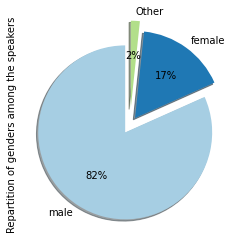

In [295]:
explode = (0.1, 0.1, 0.2)
total_df["gender"].value_counts(normalize=True).plot(kind='pie', colors = colors, autopct='%1.0f%%', shadow= True, explode=explode, label = 'Repartition of genders among the speakers', startangle = 90)

#### By age

In [304]:
cut_labels = ['[0-18]', '[19-35]', '[36-60]', '[60+]']
cut_bins = [0, 18, 35, 60, 1000]

In [305]:
total_df['age_bracket'] = pd.cut(total_df['age'], bins=cut_bins, labels=cut_labels)

<AxesSubplot:ylabel='Repartition of age among the speakers'>

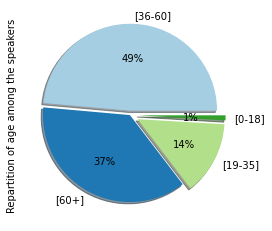

In [307]:
explode = (0.05, 0.0, 0.1, 0.1)
total_df["age_bracket"].value_counts(normalize=True).plot(kind='pie', colors = colors, autopct='%1.0f%%', shadow= True, explode=explode ,label = 'Repartition of age among the speakers')

#### By political party

<AxesSubplot:ylabel='Repartition of age among the speakers'>

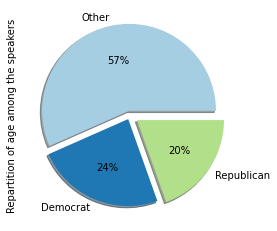

In [308]:
explode = (0.05, 0.05, 0.1)
total_df["party"].value_counts(normalize=True).plot(kind='pie', colors = colors, autopct='%1.0f%%', shadow= True, explode=explode, label = 'Repartition of age among the speakers')

## Plotting Occurrences of 'Black Lives Matter' and Counter Movements

After BLM became a movement, many people felt threatened and started asserting phrases like "Blue Lives Matter" referring to police or "All Lives Matter." Let's see when these appeared.

In [2]:
PATH_TO_FILE = 'generated/total-data-merged.pkl.bz2'
total_df = pd.read_pickle(PATH_TO_FILE, compression = 'bz2')
total_df['date'] = pd.to_datetime(total_df.date).dt.date

In [3]:
def what_lives_matter(quotation):
    quotation = quotation.lower()

    blm = ('black lives matter' in quotation)
    alm = ('all lives matter' in quotation)
    blu = ('blue lives matter' in quotation)
    white = ('white lives matter' in quotation)
    
    if blm & (not alm) & (not blu) & (not white):
        labels = 'black lives matter'
    elif alm & (not blm) & (not blu) & (not white):
        labels = 'all lives matter'
    elif blu & (not blm) & (not alm) & (not white):
        labels = 'blue lives matter'
    elif white & (not blm) & (not alm) & (not blu):
        labels = 'white lives matter'
    elif (not blm) & (not alm) & (not blu) & (not white):
        labels = None
    else:
        labels = 'multiple'
    return labels

In [4]:
data = total_df.copy()
data['date'] = data.date.astype('datetime64')
data['_lives_matter'] = data.quotation.apply(lambda x: what_lives_matter(x))
data_lm = data[(data._lives_matter != 'multiple') & (data._lives_matter.notnull())]

/Users/paularescala/opt/anaconda3/lib/python3.8/site-packages/seaborn/_core.py:163: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if palette in QUAL_PALETTES:


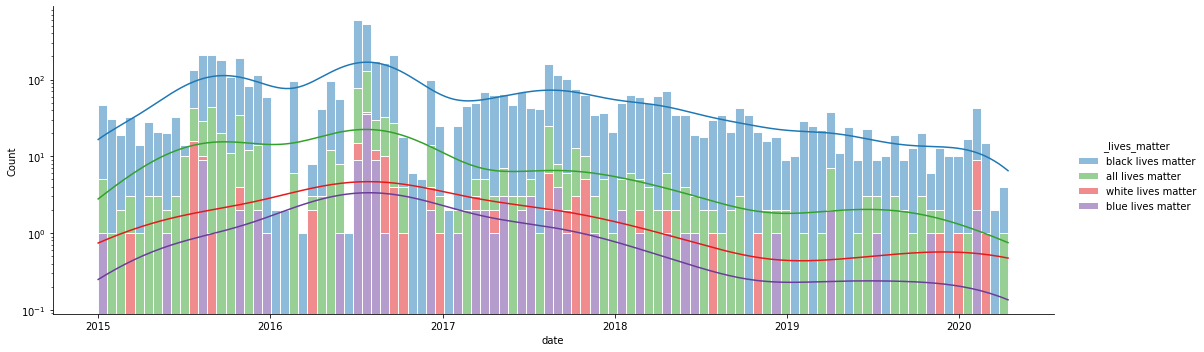

In [5]:
colors = sns.color_palette("Paired")
colors = np.array(colors)[(1,3,5,9),:]
sns.displot(data = data_lm, x = 'date', hue = '_lives_matter', 
            log_scale = [False,True], bins = 100,kind = 'hist', kde = True, 
            palette = colors,aspect = 3, edgecolor = 'white', multiple = 'stack')

plt.show()

## Named entity recognition to extract relevant names and event

In [ ]:
def get_named_entities(df, entity_types):
    ''' Does named entity recognition for every quote of a dataframe and puts the detected entities in a dictionnary. '''
    nlp = spacy.load('en_core_web_sm')
    
    # gets filled with lists of named entities of same type
    entity_dict = {}
    
    for quote in df.quotation:
        
        doc = nlp(quote)
        
        for ent in doc.ents:
            # if a quote token gets identified as a named entity and its type is included in the list entity_types
            if ent.label_ in entity_types:
                # if a previously identitied named entity was of the same entity type
                if ent.label_ in entity_dict:
                    entity_dict[ent.label_].append(ent.text)
                # if no other named entity identitied before was of the same entity type
                else:
                    entity_dict[ent.label_] = [ent.text]
    
    return entity_dict


def count_dict_entities(entities_dict, entity_types):
    ''' Counts the frequency of the entities in the dictionary. '''
    # gets filled with lists of pairs [entity, number of occurences] of same type
    entity_freq_dict = {}
    
    for key in entities_dict.keys():
        # for every entity of the list
        for ent in entities_dict[key]:
            # if key isn't in the new frequence dictionnary
            if key not in entity_freq_dict.keys():
                entity_freq_dict[key] = [[ent, entities[key].count(ent)]]
            else:
                # if entity has never been seen and counted (not written yet in the freq dictionnary)
                if [ent, entities[key].count(ent)] not in entity_freq_dict[key]:
                    entity_freq_dict[key].append([ent, entities[key].count(ent)])
    
    return entity_freq_dict


def get_entity_type_occurences(entity_type, entity_freq_dict):
    ''' Gets the number of entity occurences for a specific entity type from a frequence dictionary.'''
    ''' Returns a dataframe. '''
    
    # if input key not in input dictionnary, raise error
    if entity_type not in entity_freq_dict.keys():
        raise TypeError(f"{entity_type} isn't an entity_freq_dict key, should be either of these: {entity_freq_dict.keys()}")
    
    # select one entity type
    entity_occ_pairs = entity_freq_dict[entity_type]
    entity_name = []
    entity_occ = []
    
    for pair in entity_occ_pairs:
        entity_name.append(pair[0])
        entity_occ.append(pair[1])
    
    occurences_df = pd.DataFrame(data = { 'entityName' : entity_name,
                                         'numOccurrences' : entity_occ}
                                )
    occurences_df = occurences_df.sort_values(by=['numOccurrences'], ascending=False)

    return occurences_df

In [ ]:
entity_types = ['PERSON']
# Does named entity recognition for every quote of a dataframe and puts the detected entities in a dictionnary
entities = get_named_entities(total_df.copy(), entity_types)

In [ ]:
# Counts the frequency of the entities in the dictionary
entity_freq = count_dict_entities(entities, 'PERSON')
# Gets the number of entity occurences for a specific entity type from a frequence dictionary and returns a dataframe
get_entity_type_occurences('PERSON', entity_freq).to_csv(path_or_buf = 'named_entity_rec.bz2', compression = 'bz2', mode = 'a')

In [317]:
occurrences_df=pd.read_csv('named_entity_rec.bz2')
occurrences_df = occurrences_df[['entityName', 'numOccurrences']]
occurrences_df.head()

,entityName,numOccurrences
0,Trump,4260
1,Colin Kaepernick,2363
2,Donald Trump,1519
3,Lynch,781
4,Loretta Lynch,764


In [120]:
names_blm = pd.DataFrame({'name': ['Walter Scott', 'Sandra Bland', 'Philando Castile', 'Alton Sterling', 'Terence Crutcher', 'Stephon Clark', 'Botham Jean', 'Colin Kaepernick', 'Jordan Edwards'], 'date': [datetime(2015, 4, 4) ,datetime(2015, 7, 13), datetime(2016, 7, 6), datetime(2016, 7, 5), datetime(2016, 9, 16), datetime(2018, 3, 18), datetime(2018, 9, 6), datetime(2016, 9, 1), datetime(2017, 4, 29)]})
names_blm = names_blm.sort_values(by='date')
names_blm

,name,date
0,Walter Scott,2015-04-04
1,Sandra Bland,2015-07-13
3,Alton Sterling,2016-07-05
2,Philando Castile,2016-07-06
7,Colin Kaepernick,2016-09-01
4,Terence Crutcher,2016-09-16
8,Jordan Edwards,2017-04-29
5,Stephon Clark,2018-03-18
6,Botham Jean,2018-09-06


## Computing the days elapsed after the last 'famous' police killing or meaningful events related to BLM and correlating it with the number of occurences

In [126]:
names_blm

,name,date
0,Walter Scott,2015-04-04
1,Sandra Bland,2015-07-13
3,Alton Sterling,2016-07-05
2,Philando Castile,2016-07-06
7,Colin Kaepernick,2016-09-01
4,Terence Crutcher,2016-09-16
8,Jordan Edwards,2017-04-29
5,Stephon Clark,2018-03-18
6,Botham Jean,2018-09-06


In [122]:
#Finding the last event that happened for each date in the dataframe

total_df['last_event_date'] = np.nan #initialize a new column in the dataframe


total_df['date'] = pd.to_datetime(total_df['date'])

for index, row in total_df.iterrows():
    row_date = row['date']
    past_dates = names_blm[names_blm['date'] < row_date] # all the events that happened before the current date
    last_dates = np.max(past_dates['date']) # select the last one 
    total_df.at[index, 'last_event_date'] = last_dates #fill the last_event_date column

In [123]:
#Computing the days that elapsed between the date of the quotation and the last relevant event

total_df['days_after_last_event'] = (total_df['date'] - total_df['last_event_date']).dt.days

C:\Users\_\anaconda3\lib\site-packages\pandas\core\arrays\datetimelike.py:1187: PerformanceWarning: Adding/subtracting object-dtype array to DatetimeArray not vectorized
  warnings.warn(


In [124]:
total_df['nb_quotations']=total_df.groupby(['date'])['numOccurrences'].transform(sum)
total_df

,quotation,speaker,qids,date,numOccurrences,domains,speaker_probability,date_of_birth,nationality,gender,...,party,academic_degree,label,religion,age,age_bracket,sentiment_scores,last_event_date,days_after_last_event,nb_quotations
quoteID,,,,,,,,,,,,,,,,,,,,,
2015-06-02-000948,"However, in the meantime compulsory encryption...",Chris McIntosh,Q5107420,2015-06-02,1,[computerweekly],0.8306,1977-02-20,United States of America,male,...,None,None,Chris McIntosh,None,38.0,[36-60],0.2500,2015-04-04 00:00:00,59.0,15
2015-09-20-001335,A missile landed on the house of Abdul Waheed ...,Zahid Khan,Q24005455,2015-09-20,1,[tribune],0.8935,1976-01-01,None,male,...,None,None,Zahid Khan,None,39.0,[36-60],0.0000,2015-07-13 00:00:00,69.0,758
2015-10-21-003064,a remarkable demonstration of chutzpah.,Ben Bernanke,Q201795,2015-10-21,1,[washingtonpost],0.7873,1953-12-13,United States of America,male,...,Republican,None,Ben Bernanke,Judaism,61.0,[60+],0.6124,2015-07-13 00:00:00,100.0,2936
2015-01-06-021216,I couldn't help but think of the disrespect th...,Michael Harrison,Q17414590,2015-01-06,1,[fox8live],0.6762,NaT,None,male,...,None,None,Michael Harrison,None,NaN,NaN,-0.6518,NaT,NaN,962
2015-05-29-001442,"according to David Lynch, I WILL be involved i...",Sheryl Lee,Q233593,2015-05-29,2,"[express, express]",0.5384,1967-04-22,United States of America,female,...,None,None,Sheryl Lee,None,48.0,[36-60],0.0000,2015-04-04 00:00:00,55.0,404
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2020-01-14-074227,The IMB PRC is grateful to Singapore law enfor...,Michael Howlett,Q58427075,2020-01-14,1,[hellenicshippingnews],0.8313,NaT,None,None,...,None,None,Michael Howlett,None,NaN,NaN,0.4588,2018-09-06 00:00:00,495.0,1159
2020-02-03-082123,"They always indulge in vote bank politics, app...",Narendra Modi,Q1058,2020-02-03,1,[hindustantimes],0.9083,1950-09-17,India,male,...,Other,None,Narendra Modi,Hinduism,69.0,[60+],0.6072,2018-09-06 00:00:00,515.0,1195
2020-01-10-086593,This is a recommendation from our Capitol Poli...,Charniele Herring,Q5086555,2020-01-10,4,"[ideastations, ideastations, ammoland, ideasta...",0.8648,1969-09-25,United States of America,female,...,Democrat,None,Charniele Herring,None,50.0,[36-60],0.8591,2018-09-06 00:00:00,491.0,2501


In [127]:
#Pearsons correlations between the number of quotations and the number of days after the last death
print(total_df['nb_quotations'].corr(total_df['days_after_last_event']))

-0.24647852523068042


We expect a negative correlation between the number of quotations and the number of days elapsed since the last unlegitimate fatal police shooting. Indeed, the closer to the event, the more quotations we expect. 

In [128]:
names_blm

,name,date
0,Walter Scott,2015-04-04
1,Sandra Bland,2015-07-13
3,Alton Sterling,2016-07-05
2,Philando Castile,2016-07-06
7,Colin Kaepernick,2016-09-01
4,Terence Crutcher,2016-09-16
8,Jordan Edwards,2017-04-29
5,Stephon Clark,2018-03-18
6,Botham Jean,2018-09-06


## Occurrences of big names in the quotations

In [129]:
def filter_by_keywords(chunk, keywords):
    '''Return the rows of the dataframe only if the quotation contains any token in the keywords list.'''
    chunk_lower = chunk.copy()
    chunk_lower['quotation'] = chunk.quotation.str.lower()
    keys = []
    for key in keywords:
        keys.append(key.lower())
    chunk = chunk[chunk_lower.quotation.str.contains('|'.join(keys))]
    
    return chunk

In [130]:
keywords = names_blm.name

In [131]:
#Copying the dataframe to make sure that I don't alter the original dataframe filtering it

test = total_df.copy()

In [133]:
occ = []

for name in keywords : 
    first_occ = filter_by_keywords(test, [name])
    first_occ.sort_values(by = 'date')
    occ.append(first_occ.date.min())

In [134]:
names_blm = names_blm.assign(first_mention=occ)
names_blm

,name,date,first_mention
0,Walter Scott,2015-04-04,2015-02-06
1,Sandra Bland,2015-07-13,2015-07-16
3,Alton Sterling,2016-07-05,2016-07-05
2,Philando Castile,2016-07-06,2016-07-07
7,Colin Kaepernick,2016-09-01,2015-01-01
4,Terence Crutcher,2016-09-16,2016-09-19
8,Jordan Edwards,2017-04-29,2017-05-06
5,Stephon Clark,2018-03-18,2018-03-21
6,Botham Jean,2018-09-06,2018-09-10


## Peak detection : need to add the dates of the 'famous' killings on top of it

In [276]:
palette = sns.color_palette(None, len(names_blm) + 1)

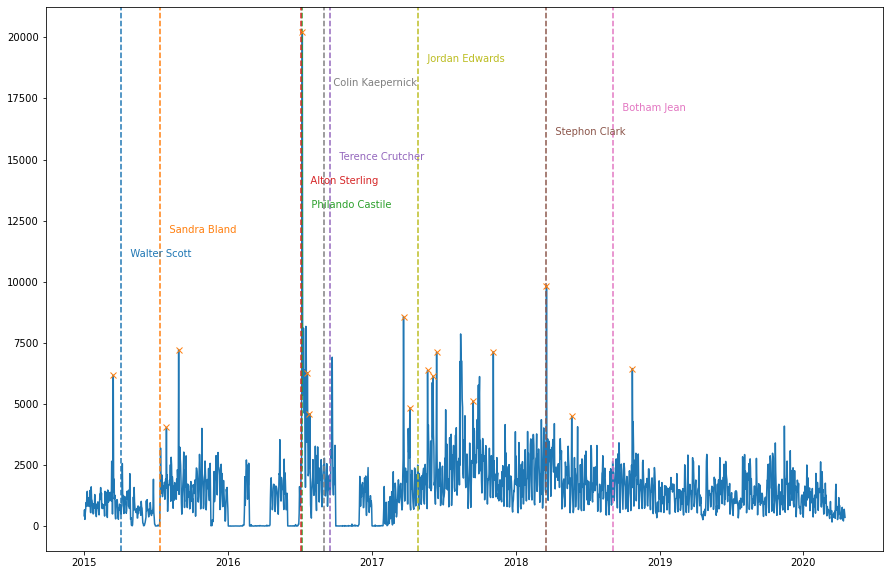

In [277]:
fig, ax = plt.subplots(figsize=(15, 10))
x = total_df.groupby('date', as_index=False).count()["date"]
y = total_df.groupby('date', as_index=False).sum()['numOccurrences']
plt.plot(x,y)
idx, properties = find_peaks(y, threshold = 2000, width=1)

for i in range(0,len(names_blm)):
    plt.axvline(names_blm.date[i], 0, 30000,color = palette[i], linestyle ="--")
    style = dict(size=10, color=palette[i])
    ax.text(names_blm.date[i], 11000 + i*1000, '   ' + names_blm.name[i], **style)
    
plt.plot(x[idx], y[idx], "x")

In [142]:
print("The main peaks correspond to the following dates :\n",x[idx])

The main peaks correspond to the following dates :
 74     2015-03-16
209    2015-07-29
240    2015-08-29
551    2016-07-08
564    2016-07-21
568    2016-07-25
807    2017-03-22
823    2017-04-07
868    2017-05-22
882    2017-06-05
891    2017-06-14
984    2017-09-15
1035   2017-11-05
1170   2018-03-20
1234   2018-05-23
1388   2018-10-24
Name: date, dtype: datetime64[ns]


#### We saw that the occurrences of a few people killed unlegitimately by the police in the years before 2015 still occur often in our dataset. For example let's look at the occurrences of the name of Trayvon Martin, killed in 2012

C:\Users\_\anaconda3\lib\site-packages\numpy\ma\core.py:6845: RuntimeWarning: overflow encountered in power
  result = np.where(m, fa, umath.power(fa, fb)).view(basetype)
C:\Users\_\anaconda3\lib\site-packages\numpy\ma\core.py:6845: RuntimeWarning: overflow encountered in power
  result = np.where(m, fa, umath.power(fa, fb)).view(basetype)
C:\Users\_\anaconda3\lib\site-packages\numpy\ma\core.py:6845: RuntimeWarning: overflow encountered in power
  result = np.where(m, fa, umath.power(fa, fb)).view(basetype)
C:\Users\_\anaconda3\lib\site-packages\numpy\ma\core.py:6845: RuntimeWarning: overflow encountered in power
  result = np.where(m, fa, umath.power(fa, fb)).view(basetype)
C:\Users\_\anaconda3\lib\site-packages\numpy\ma\core.py:6845: RuntimeWarning: overflow encountered in power
  result = np.where(m, fa, umath.power(fa, fb)).view(basetype)
C:\Users\_\anaconda3\lib\site-packages\numpy\ma\core.py:6845: RuntimeWarning: overflow encountered in power
  result = np.where(m, fa, umath.powe

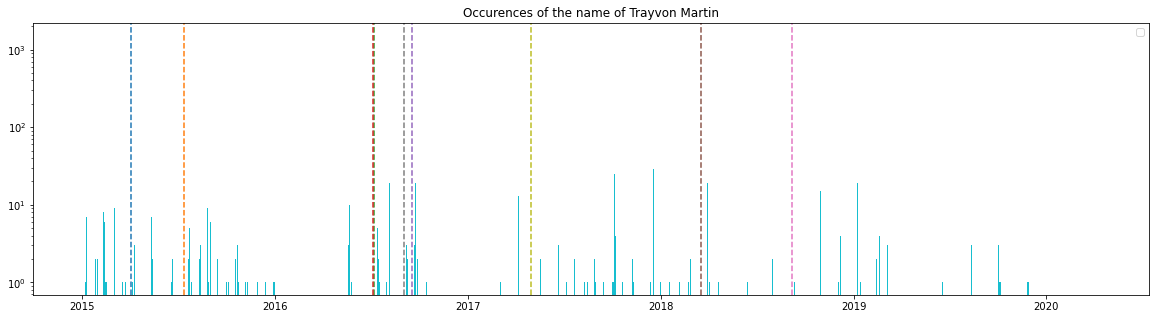

In [287]:
plt.figure(figsize = (20,5))
plt.legend('Occurences of the name of Trayvon Martin')

name_df = total_df[total_df.quotation.str.contains('Trayvon Martin')]

for i in range(0,len(names_blm)):
    
    
    plt.axvline(names_blm.date[i], 0, 30000,color = palette[i], linestyle ="--", label = names_blm.name[i])
    style = dict(size=10, color=palette[i])
    #ax.text(names_blm.date[i], 11000 + i*1000, '   ' + names_blm.name[i], **style)

    x = name_df.groupby('date', as_index=False).count()["date"]
    height = name_df.groupby('date', as_index=False).sum()['numOccurrences']
    plt.bar(x,height, color = palette[len(names_blm)], width=0.4, log=True)
    plt.title(label = 'Occurences of the name of Trayvon Martin')
    
    


We can see peaks of occurrences of the name of Trayvon Martin after the deaths of the people we selected or the act of protestation of Colin Kaepernick.

## Let's analyse the dataset just before and just after our events

In [215]:
def pie_chart_sentiment(dataframe, colors):
    dataframe['sent_bracket'] = pd.cut(dataframe['sentiment_scores'], bins=cut_bins2, labels=cut_labels2)
    explode = (0.05, 0.05, 0.05)
    df_out = dataframe["sent_bracket"].value_counts(normalize=True)
    
    return df_out

C:\Users\_\anaconda3\lib\site-packages\pandas\core\indexing.py:1732: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)
C:\Users\_\anaconda3\lib\site-packages\pandas\core\indexing.py:1732: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)
C:\Users\_\anaconda3\lib\site-packages\pandas\core\indexing.py:1732: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-cop

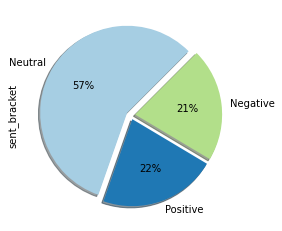

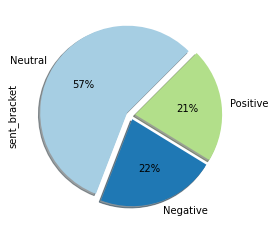

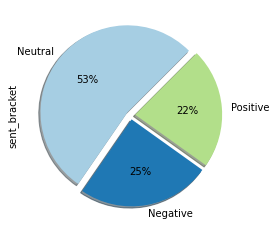

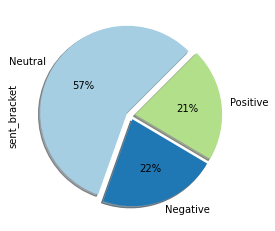

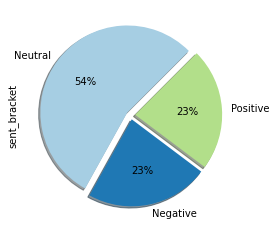

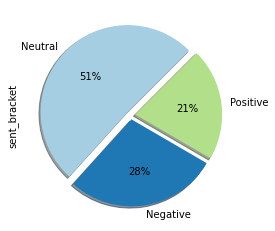

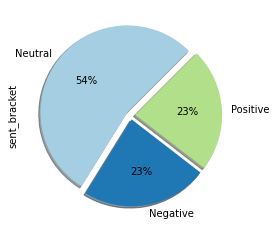

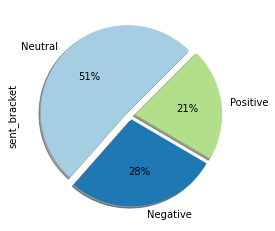

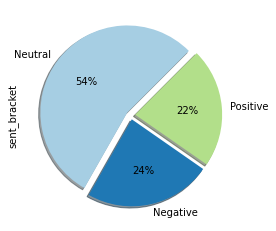

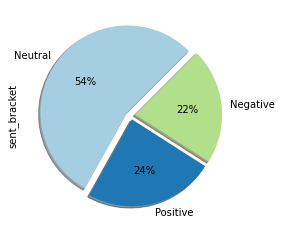

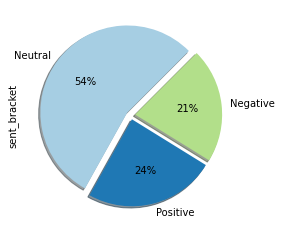

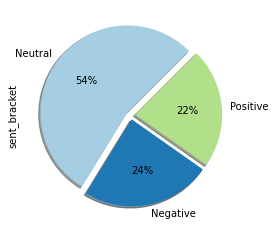

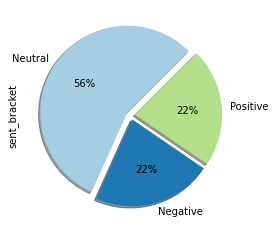

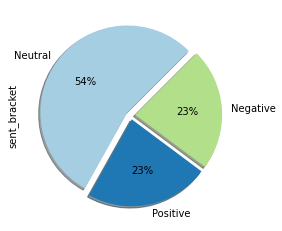

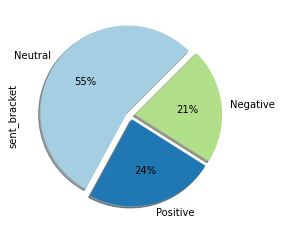

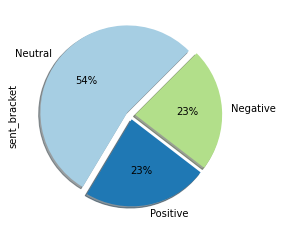

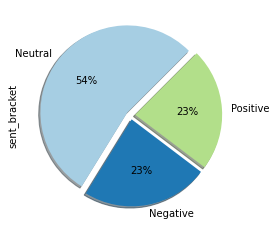

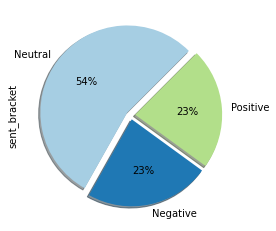

In [217]:
names_blm['quotations_after'] = 0
names_blm['quotations_before'] = 0
names_blm['relative_increase'] = 0

for i in range(0,len(names_blm)):
    
    killing_date = names_blm['date'].iloc[i]
    
    day_before_kill =  total_df[((quotes_sent['date'] <= killing_date))]
    day_before_kill = day_before_kill[(day_before_kill['date'] > killing_date - timedelta(days=15))]
    
    names_blm['quotations_before'].iloc[i] = day_before_kill['numOccurrences'].sum()
    
    fig, ax = plt.subplots(figsize=(6, 4))
    
    df_out = pie_chart_sentiment(day_before_kill, colors)
    df_out.plot(kind='pie', colors = colors, autopct='%1.0f%%', shadow= True, explode=explode, startangle = 45)
    
    day_after_kill =  quotes_sent[((quotes_sent['date'] >= killing_date))]
    day_after_kill =  day_after_kill[(day_after_kill['date'] < killing_date + timedelta(days=15))]
    
    names_blm['quotations_after'].iloc[i] = day_after_kill['numOccurrences'].sum()
    
    fig, ax = plt.subplots(figsize=(6, 4))
    
    df_out = pie_chart_sentiment(day_after_kill, colors)
    df_out.plot(kind='pie', colors = colors, autopct='%1.0f%%', shadow= True, explode=explode, startangle = 45)
    
names_blm['relative_increase'] = (names_blm.quotations_after - names_blm.quotations_before)/names_blm.quotations_before

In [179]:
names_blm['norm_increase'] = (names_blm.relative_increase - names_blm.relative_increase.min()) /(names_blm.relative_increase.max() - names_blm.relative_increase.min())

In [180]:
names_blm

,name,date,first_mention,quotations_after,quotations_before,relative_increase,norm_increase
0,Walter Scott,2015-04-04,2015-02-06,14764,10812,0.365520,0.025789
1,Sandra Bland,2015-07-13,2015-07-16,25109,1627,14.432698,1.000000
3,Alton Sterling,2016-07-05,2016-07-05,95870,8058,10.897493,0.755172
2,Philando Castile,2016-07-06,2016-07-07,96908,10352,8.361283,0.579529
7,Colin Kaepernick,2016-09-01,2015-01-01,27671,27862,-0.006855,0.000000
4,Terence Crutcher,2016-09-16,2016-09-19,40540,27104,0.495720,0.034805
8,Jordan Edwards,2017-04-29,2017-05-06,23959,23331,0.026917,0.002339
5,Stephon Clark,2018-03-18,2018-03-21,44293,35094,0.262125,0.018628
6,Botham Jean,2018-09-06,2018-09-10,28814,22798,0.263883,0.018750


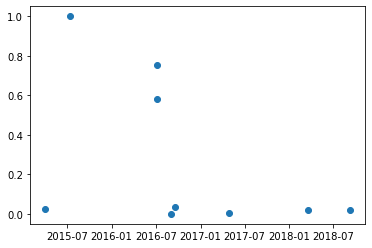

In [183]:
plt.scatter(names_blm.date, names_blm.norm_increase)
plt.show()

## Sentiment analysis

In [80]:
quotes_sent = total_df.copy() # dataframe to run the sentiment analysis on
quotes_sent

,quotation,speaker,qids,date,numOccurrences,domains,speaker_probability,date_of_birth,nationality,gender,ethnic_group,occupation,party,academic_degree,label,religion,age,age_bracket
quoteID,,,,,,,,,,,,,,,,,,
2015-06-02-000948,"However, in the meantime compulsory encryption...",Chris McIntosh,Q5107420,2015-06-02,1,[computerweekly],0.8306,1977-02-20,United States of America,male,None,American football player,None,None,Chris McIntosh,None,38.0,[36-60]
2015-09-20-001335,A missile landed on the house of Abdul Waheed ...,Zahid Khan,Q24005455,2015-09-20,1,[tribune],0.8935,1976-01-01,None,male,None,cricketer,None,None,Zahid Khan,None,39.0,[36-60]
2015-10-21-003064,a remarkable demonstration of chutzpah.,Ben Bernanke,Q201795,2015-10-21,1,[washingtonpost],0.7873,1953-12-13,United States of America,male,Jewish people,"[economist, politician, professor, banker]",Republican,None,Ben Bernanke,Judaism,61.0,[60+]
2015-01-06-021216,I couldn't help but think of the disrespect th...,Michael Harrison,Q17414590,2015-01-06,1,[fox8live],0.6762,NaT,None,male,None,radio personality,None,None,Michael Harrison,None,NaN,NaN
2015-05-29-001442,"according to David Lynch, I WILL be involved i...",Sheryl Lee,Q233593,2015-05-29,2,"[express, express]",0.5384,1967-04-22,United States of America,female,None,"[actor, stage actor, television actor, film ac...",None,None,Sheryl Lee,None,48.0,[36-60]
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2020-01-14-074227,The IMB PRC is grateful to Singapore law enfor...,Michael Howlett,Q58427075,2020-01-14,1,[hellenicshippingnews],0.8313,NaT,None,None,None,researcher,None,None,Michael Howlett,None,NaN,NaN
2020-02-03-082123,"They always indulge in vote bank politics, app...",Narendra Modi,Q1058,2020-02-03,1,[hindustantimes],0.9083,1950-09-17,India,male,"[Gujarati people, Modh]","[politician, writer, social worker, bibliograp...",Other,None,Narendra Modi,Hinduism,69.0,[60+]
2020-01-10-086593,This is a recommendation from our Capitol Poli...,Charniele Herring,Q5086555,2020-01-10,4,"[ideastations, ideastations, ammoland, ideasta...",0.8648,1969-09-25,United States of America,female,African Americans,"[lawyer, politician]",Democrat,None,Charniele Herring,None,50.0,[36-60]


In [81]:
analyzer = SentimentIntensityAnalyzer() # initialize analyzer
quotes_sent['sentiment_scores'] = quotes_sent['quotation'].apply(lambda quotation: analyzer.polarity_scores(quotation)['compound'])
#quotes_sent['date'] = pd.to_datetime(quotes_sent['date'], errors='coerce')

quotes_sent.head(2)
quotes_sent['date'] = pd.to_datetime(quotes_sent['date'])

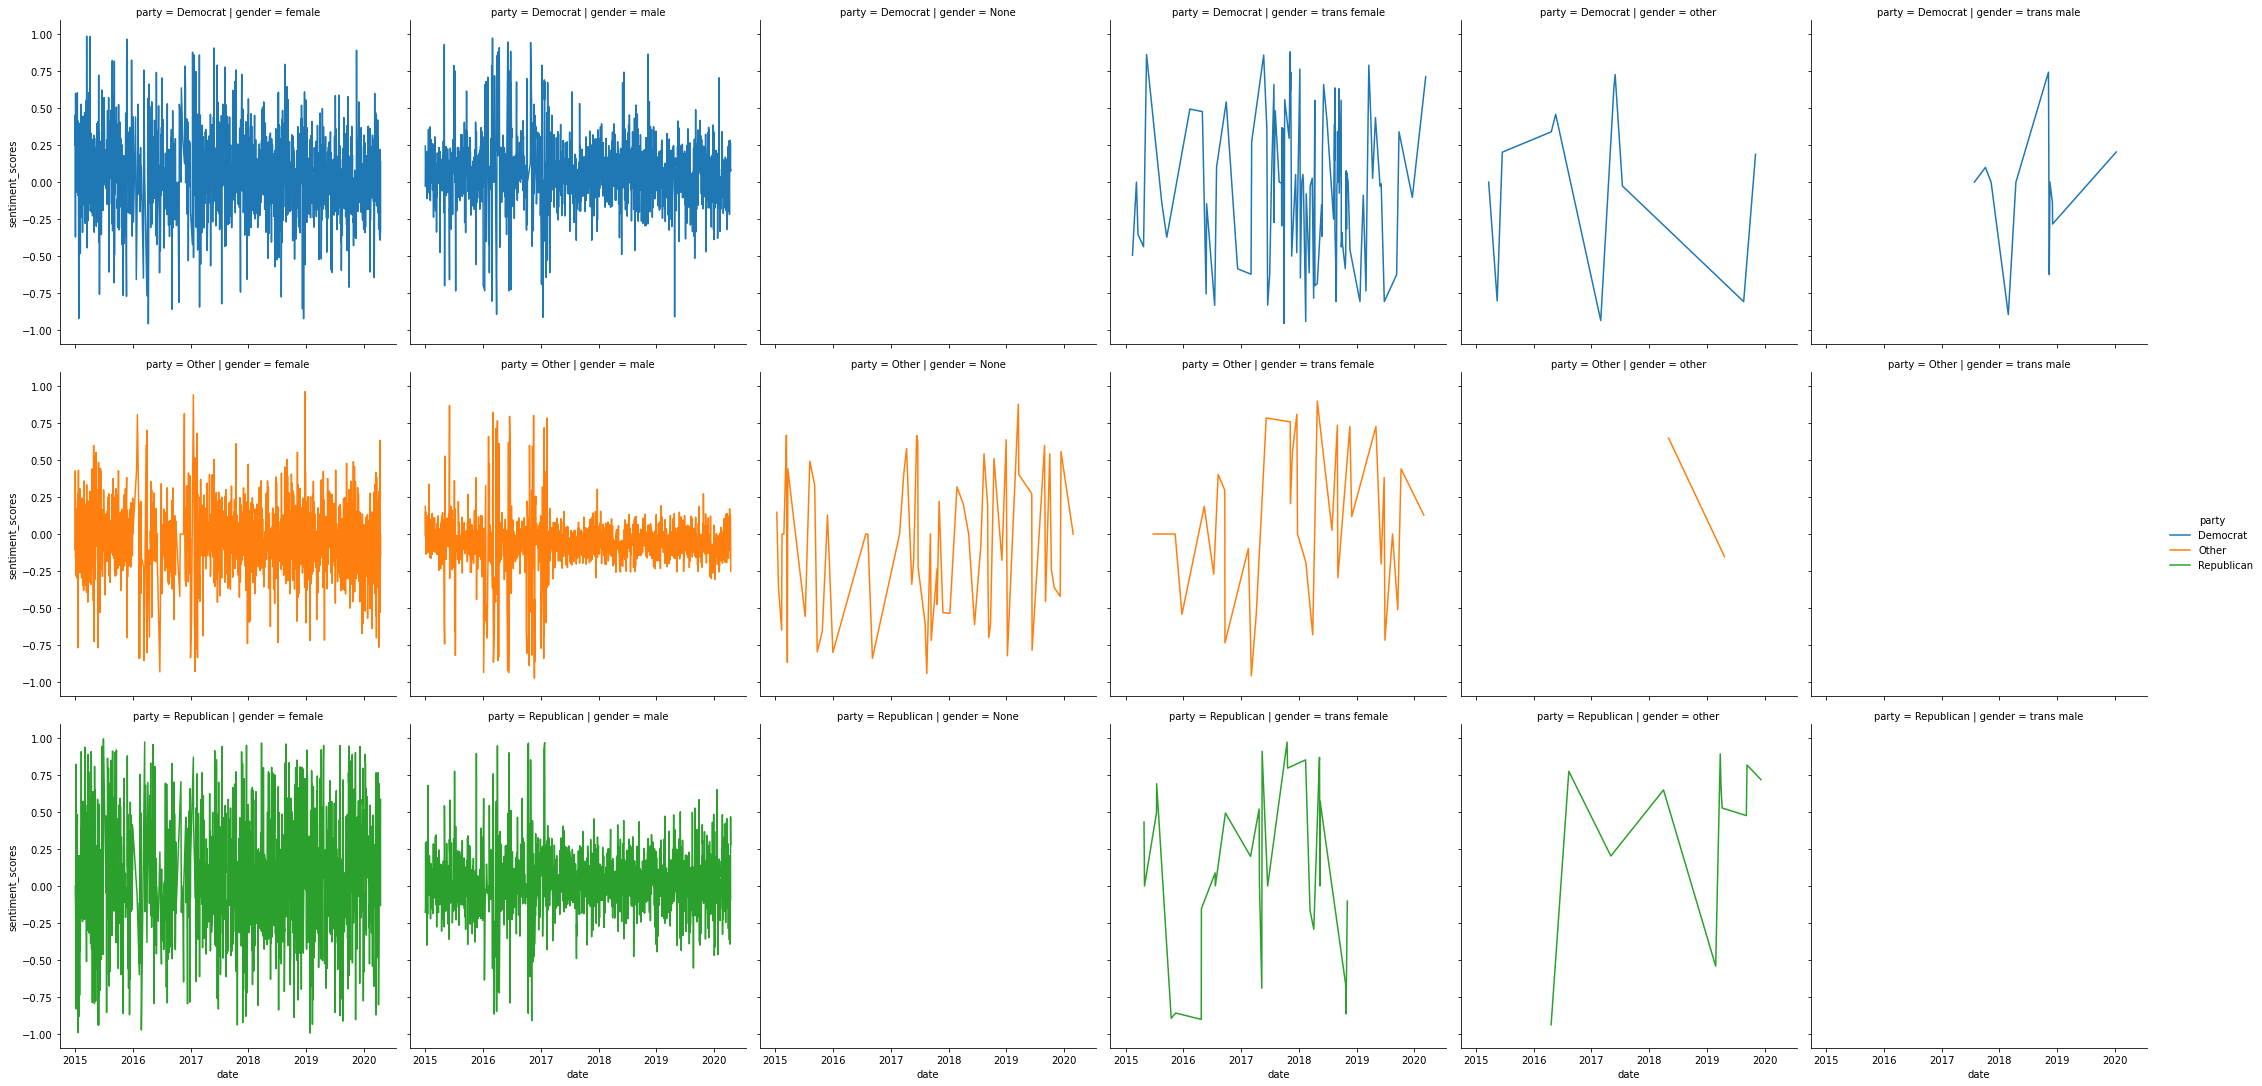

In [84]:
# group by columns and get the average sentiment polarity scores
group_by_cols = ["date", "gender", "party"]
plot_df = quotes_sent.copy().sort_values(by='date')
plot_df = plot_df.groupby(group_by_cols, as_index=False)['sentiment_scores'].mean()

#fig, ax = plt.subplots(figsize = (20,6))
sns.relplot(data=plot_df, x="date", y="sentiment_scores", col="gender", hue="party", kind="line", row="party")
#fig.autofmt_xdate()

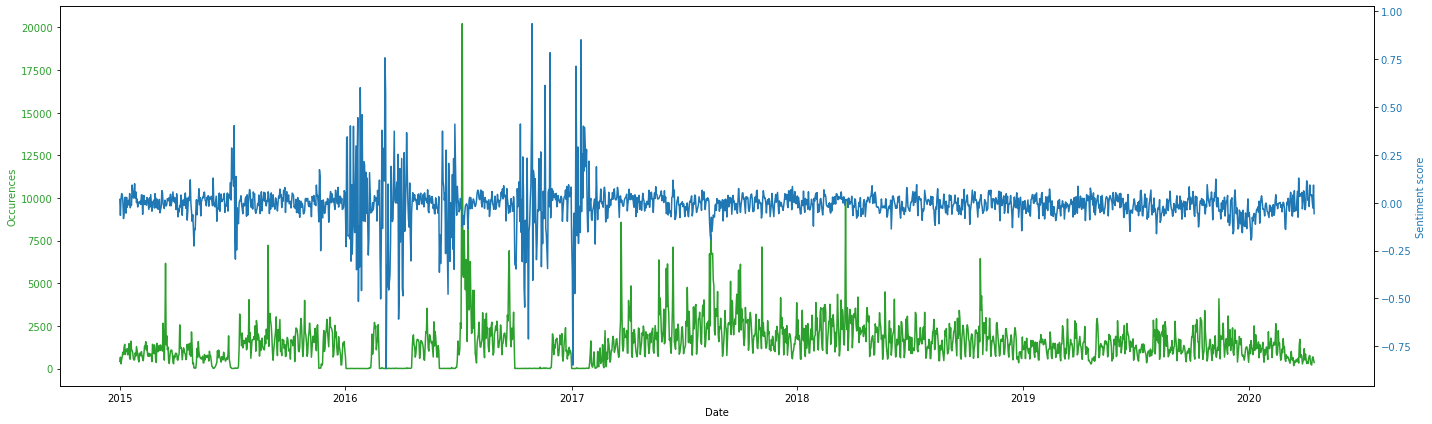

In [86]:
plot_df = quotes_sent.copy()[['date', 'quotation', 'speaker', 'qids', 'sentiment_scores']].sort_values(by='date')

x = quotes_sent.groupby('date', as_index=False).count()["date"]
y = quotes_sent.groupby('date', as_index=False).sum()["numOccurrences"]
z = plot_df.groupby(plot_df['date'])['sentiment_scores'].mean()

fig, ax1 = plt.subplots(figsize=(20,6))

color = 'tab:green'
ax1.set_xlabel('Date')
ax1.set_ylabel('Occurences', color=color)
ax1.plot(x, y, color=color)
ax1.tick_params(axis='y', labelcolor=color)

ax2 = ax1.twinx()

color = 'tab:blue'
ax2.set_ylabel('Sentiment score', color=color)
ax2.plot(x, z, color=color)
ax2.tick_params(axis='y', labelcolor=color)


fig.tight_layout()
plt.show()

## Vizualizations using the sentiment scores : cannot see the impact of the different features --> cannot draw conclusions from this part

In [218]:
#Keeping only the relevant columns and analysis the politicians 

df_charts = pd.DataFrame(quotes_sent, columns=['date', 'sentiment_scores', 'gender', 'party', 'date_of_birth', 'age_bracket'])
df_charts

,date,sentiment_scores,gender,party,date_of_birth,age_bracket
quoteID,,,,,,
2015-06-02-000948,2015-06-02,0.2500,male,None,1977-02-20,[36-60]
2015-09-20-001335,2015-09-20,0.0000,male,None,1976-01-01,[36-60]
2015-10-21-003064,2015-10-21,0.6124,male,Republican,1953-12-13,[60+]
2015-01-06-021216,2015-01-06,-0.6518,male,None,NaT,NaN
2015-05-29-001442,2015-05-29,0.0000,female,None,1967-04-22,[36-60]
...,...,...,...,...,...,...
2020-01-14-074227,2020-01-14,0.4588,None,None,NaT,NaN
2020-02-03-082123,2020-02-03,0.6072,male,Other,1950-09-17,[60+]
2020-01-10-086593,2020-01-10,0.8591,female,Democrat,1969-09-25,[36-60]


In [219]:
#Selecting the rows where the sentiment score is 0.75 or higher

df_charts = df_charts[df_charts['sentiment_scores']>=0.75]
df_charts

,date,sentiment_scores,gender,party,date_of_birth,age_bracket
quoteID,,,,,,
2015-03-30-002184,2015-03-30,0.8481,female,None,NaT,NaN
2015-03-20-010493,2015-03-20,0.8625,male,Other,1953-09-13,[60+]
2015-01-19-008768,2015-01-19,0.8829,male,Republican,1943-05-10,[60+]
2015-04-15-044350,2015-04-15,0.8779,male,None,1961-09-22,[36-60]
2015-03-24-025408,2015-03-24,0.9231,male,None,1952-06-11,[60+]
...,...,...,...,...,...,...
2020-01-31-042433,2020-01-31,0.8774,female,Other,1955-01-05,[60+]
2020-01-10-040301,2020-01-10,0.8402,female,None,NaT,NaN
2020-04-16-023572,2020-04-16,0.7579,male,None,1998-12-26,[19-35]


#### For political party

<AxesSubplot:ylabel='party'>

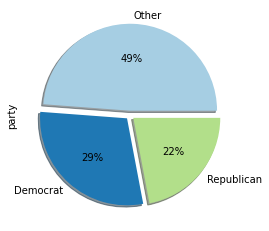

In [220]:
explode = (0.05, 0.05, 0.05)
df_charts["party"].value_counts(normalize=True).plot(kind='pie', colors = colors, autopct='%1.0f%%', shadow= True, explode=explode)

#### For age

<AxesSubplot:ylabel='age_bracket'>

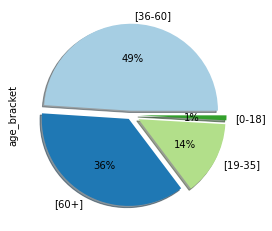

In [221]:
explode = (0.05, 0.05, 0.1, 0.1)
df_charts["age_bracket"].value_counts(normalize=True).plot(kind='pie', colors = colors, autopct='%1.0f%%', shadow= True, explode=explode)

#### For gender

<AxesSubplot:ylabel='age_bracket'>

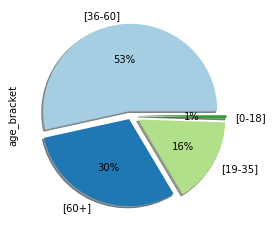

In [222]:
explode = (0.05, 0.05, 0.1, 0.1)
df_charts[df_charts['gender'] == 'female']["age_bracket"].value_counts(normalize=True).plot(kind='pie', colors = colors, autopct='%1.0f%%', shadow= True, explode=explode)

<AxesSubplot:ylabel='gender'>

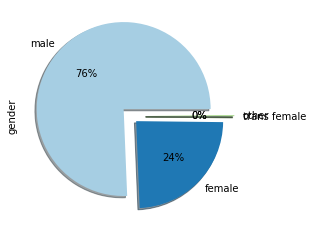

In [153]:
explode = (0.1, 0.1, 0.2, 0.2)
df_charts["gender"].value_counts(normalize=True).plot(kind='pie', colors = colors, autopct='%1.0f%%', shadow= True, explode=explode)

#### Putting the sentiment scores into bins and generating pie charts to see the influence of the different features

In [200]:
#Reloading the df_charts dataframe so that the sentiment scores are not filtered

df_charts = pd.DataFrame(quotes_politicians, columns=['date', 'sentiment_scores', 'gender', 'party', 'date_of_birth', 'age_bracket'])

cut_labels2 = ['Negative', 'Neutral', 'Positive']
cut_bins2 = [-1, -0.5, 0.5, 1]

In [201]:
df_charts['sent_bracket'] = pd.cut(df_charts['sentiment_scores'], bins=cut_bins2, labels=cut_labels2)

In [202]:
df_charts

,date,sentiment_scores,gender,party,date_of_birth,age_bracket,sent_bracket
quoteID,,,,,,,
2015-10-21-003064,2015-10-21,0.6124,male,Republican,1953-12-13,[60+],Positive
2015-03-26-004262,2015-03-26,0.3197,female,Democrat,1953-07-24,[60+],Neutral
2015-01-19-008768,2015-01-19,0.8829,male,Republican,1943-05-10,[60+],Positive
2015-10-23-016772,2015-10-23,0.0000,male,Republican,1960-12-14,[36-60],Neutral
2015-04-01-055183,2015-04-01,0.0000,female,Republican,1967-11-10,[36-60],Neutral
...,...,...,...,...,...,...,...
2020-04-07-056022,2020-04-07,0.0000,male,Democrat,1961-05-08,[36-60],Neutral
2020-03-04-015186,2020-03-04,0.0000,male,Republican,1959-09-12,[36-60],Neutral
2020-02-11-046243,2020-02-11,-0.2023,male,Democrat,1973-06-23,[36-60],Neutral


<AxesSubplot:ylabel='sent_bracket'>

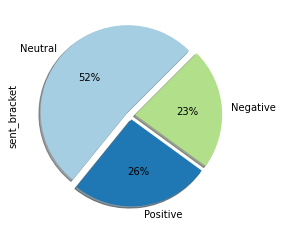

In [204]:
explode = (0.05, 0.05, 0.05)
df_charts["sent_bracket"].value_counts(normalize=True).plot(kind='pie', colors = colors, autopct='%1.0f%%', shadow= True, explode=explode, startangle = 45)

<AxesSubplot:ylabel='sent_bracket'>

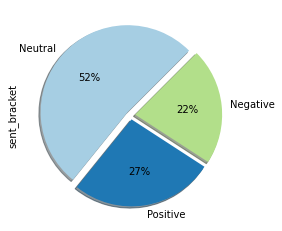

In [206]:
df_charts[(df_charts['gender'] == 'male') & (df_charts['party'] == 'Democrat')]["sent_bracket"].value_counts(normalize=True).plot(kind='pie', colors = colors, autopct='%1.0f%%', shadow= True, explode=explode, startangle = 45)

<AxesSubplot:ylabel='sent_bracket'>

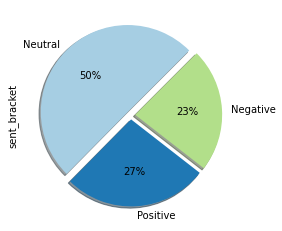

In [207]:
df_charts[(df_charts['gender'] == 'female') & (df_charts['party'] == 'Democrat')]["sent_bracket"].value_counts(normalize=True).plot(kind='pie', colors = colors, autopct='%1.0f%%', shadow= True, explode=explode, startangle = 45)

<AxesSubplot:ylabel='sent_bracket'>

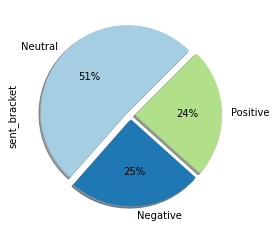

In [208]:
df_charts[df_charts['age_bracket'] == '[19-35]']["sent_bracket"].value_counts(normalize=True).plot(kind='pie', colors = colors, autopct='%1.0f%%', shadow= True, explode=explode, startangle = 45)

<AxesSubplot:ylabel='sent_bracket'>

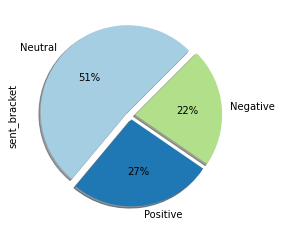

In [209]:
df_charts[df_charts['age_bracket'] == '[36-60]']["sent_bracket"].value_counts(normalize=True).plot(kind='pie', colors = colors, autopct='%1.0f%%', shadow= True, explode=explode, startangle = 45)

<AxesSubplot:ylabel='sent_bracket'>

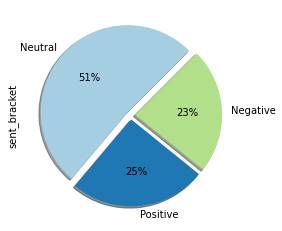

In [210]:
df_charts[df_charts['age_bracket'] == '[60+]']["sent_bracket"].value_counts(normalize=True).plot(kind='pie', colors = colors, autopct='%1.0f%%', shadow= True, explode=explode, startangle = 45)

<AxesSubplot:ylabel='sent_bracket'>

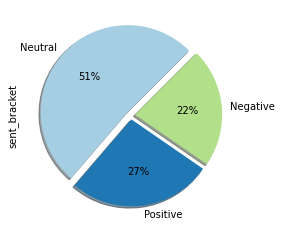

In [211]:
df_charts[df_charts['party'] == 'Democrat']["sent_bracket"].value_counts(normalize=True).plot(kind='pie', colors = colors, autopct='%1.0f%%', shadow= True, explode=explode, startangle = 45)

<AxesSubplot:ylabel='sent_bracket'>

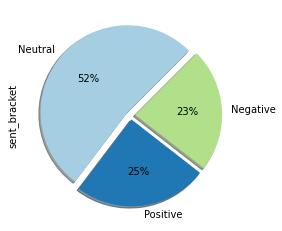

In [212]:
df_charts[df_charts['party'] == 'Republican']["sent_bracket"].value_counts(normalize=True).plot(kind='pie', colors = colors, autopct='%1.0f%%', shadow= True, explode=explode, startangle = 45)

<AxesSubplot:ylabel='sent_bracket'>

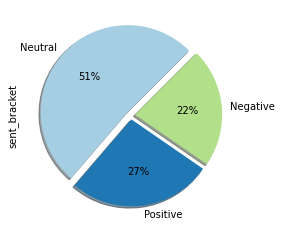

In [213]:
df_charts[df_charts['party'] == 'Democrat']["sent_bracket"].value_counts(normalize=True).plot(kind='pie', colors = colors, autopct='%1.0f%%', shadow= True, explode=explode, startangle = 45)

We can see that no matter how we filter the speakers it does not affect the sentiment scores so we cannot get some conclusions with those pie charts. 

## Regression analysis between the sentiment scores and the different features of the speaker

### Onehot columns for gender, age and party

In [184]:
quotes_politicians.head(5)

,quotation,speaker,qids,date,numOccurrences,domains,speaker_probability,date_of_birth,nationality,gender,...,party,academic_degree,label,religion,age,age_bracket,sentiment_scores,last_event_date,days_after_last_event,nb_quotations
quoteID,,,,,,,,,,,,,,,,,,,,,
2015-10-21-003064,a remarkable demonstration of chutzpah.,Ben Bernanke,Q201795,2015-10-21,1,[washingtonpost],0.7873,1953-12-13,United States of America,male,...,Republican,None,Ben Bernanke,Judaism,61.0,[60+],0.6124,2015-07-13 00:00:00,100.0,2936
2015-03-26-004262,And hopefully it will encourage people in Ferg...,Claire McCaskill,Q22260,2015-03-26,1,[stlpublicradio],0.8195,1953-07-24,United States of America,female,...,Democrat,None,Claire McCaskill,Catholic Church,61.0,[60+],0.3197,NaT,NaN,1085
2015-01-19-008768,Congratulations to our hardworking and selfles...,Richard Gordon,Q1299336,2015-01-19,2,"[inquirer, manilatimes]",0.9352,1943-05-10,United States of America,male,...,Republican,None,Richard Darman,None,71.0,[60+],0.8829,NaT,NaN,1607
2015-10-23-016772,continue the conversations we're having with t...,James Comey,Q167607,2015-10-23,1,[politico],0.8117,1960-12-14,United States of America,male,...,Republican,None,James Comey,None,54.0,[36-60],0.0000,2015-07-13 00:00:00,102.0,1657
2015-04-01-055183,"law enforcement is at a standstill,",Chrissy Adams,Q21004721,2015-04-01,13,"[wsav, yahoo, wmbfnews, wsav, mynorthwest, wec...",0.8927,1967-11-10,None,female,...,Republican,None,Chrissy Adams,None,47.0,[36-60],0.0000,NaT,NaN,899


In [185]:
# adding one hot-encoding columns of gender, age and party to dataframe
onehot_df = pd.get_dummies(quotes_politicians[['gender', 'age_bracket', 'party']]).add_suffix('_onehot')
df_extended = pd.concat([quotes_politicians, onehot_df], axis=1)

In [186]:
df_extended.head(5)

,quotation,speaker,qids,date,numOccurrences,domains,speaker_probability,date_of_birth,nationality,gender,...,gender_male_onehot,gender_other_onehot,gender_trans female_onehot,gender_trans male_onehot,age_bracket_[0-18]_onehot,age_bracket_[19-35]_onehot,age_bracket_[36-60]_onehot,age_bracket_[60+]_onehot,party_Democrat_onehot,party_Republican_onehot
quoteID,,,,,,,,,,,,,,,,,,,,,
2015-10-21-003064,a remarkable demonstration of chutzpah.,Ben Bernanke,Q201795,2015-10-21,1,[washingtonpost],0.7873,1953-12-13,United States of America,male,...,1,0,0,0,0,0,0,1,0,1
2015-03-26-004262,And hopefully it will encourage people in Ferg...,Claire McCaskill,Q22260,2015-03-26,1,[stlpublicradio],0.8195,1953-07-24,United States of America,female,...,0,0,0,0,0,0,0,1,1,0
2015-01-19-008768,Congratulations to our hardworking and selfles...,Richard Gordon,Q1299336,2015-01-19,2,"[inquirer, manilatimes]",0.9352,1943-05-10,United States of America,male,...,1,0,0,0,0,0,0,1,0,1
2015-10-23-016772,continue the conversations we're having with t...,James Comey,Q167607,2015-10-23,1,[politico],0.8117,1960-12-14,United States of America,male,...,1,0,0,0,0,0,1,0,0,1
2015-04-01-055183,"law enforcement is at a standstill,",Chrissy Adams,Q21004721,2015-04-01,13,"[wsav, yahoo, wmbfnews, wsav, mynorthwest, wec...",0.8927,1967-11-10,None,female,...,0,0,0,0,0,0,1,0,0,1


In [500]:
df_extended.info()

<class 'pandas.core.frame.DataFrame'>
Index: 130232 entries, 2015-06-02-000948 to 2015-01-11-008369
Data columns (total 32 columns):
 #   Column                      Non-Null Count   Dtype         
---  ------                      --------------   -----         
 0   quotation                   130232 non-null  object        
 1   speaker                     130232 non-null  object        
 2   qids                        130232 non-null  object        
 3   date                        130232 non-null  object        
 4   numOccurrences              130232 non-null  int64         
 5   domains                     130232 non-null  object        
 6   speaker_probability         130232 non-null  float64       
 7   date_of_birth               103793 non-null  datetime64[ns]
 8   nationality                 105957 non-null  object        
 9   gender                      128166 non-null  object        
 10  ethnic_group                14933 non-null   object        
 11  occupation       

In [187]:
df_extended.rename(columns={'gender_trans female_onehot': 'gender_trans_female_onehot', 
                           'gender_trans male_onehot': 'gender_trans_male_onehot',
                            'age_bracket_[0-18]_onehot' : 'children_onehot',
                            'age_bracket_[19-35]_onehot' : 'young_onehot' ,
                           'age_bracket_[36-60]_onehot' : 'middle_age_onehot', 
                           'age_bracket_[60+]_onehot' : 'elderly_onehot'}, inplace=True)

In [189]:
# Declares the model
mod = smf.ols(formula='sentiment_scores ~ C(party_Democrat_onehot) + C(party_Republican_onehot) + \
             C(gender_None_onehot) + C(gender_female_onehot) + C(gender_male_onehot) + \
              C(gender_other_onehot) + C(gender_trans_female_onehot) + C(gender_trans_male_onehot) +\
              C(children_onehot) + C(young_onehot) + C(middle_age_onehot) + C(elderly_onehot)', 
                data=df_extended)

In [190]:
# Fits the model (find the optimal coefficients, adding a random seed ensures consistency)
np.random.seed(2)
res = mod.fit()

In [191]:
# Print thes summary output provided by the library.
print(res.summary())

                            OLS Regression Results                            
Dep. Variable:       sentiment_scores   R-squared:                       0.001
Model:                            OLS   Adj. R-squared:                  0.001
Method:                 Least Squares   F-statistic:                     12.17
Date:                Fri, 17 Dec 2021   Prob (F-statistic):           2.39e-21
Time:                        17:37:49   Log-Likelihood:                -99311.
No. Observations:              118511   AIC:                         1.986e+05
Df Residuals:                  118500   BIC:                         1.988e+05
Df Model:                          10                                         
Covariance Type:            nonrobust                                         
                                         coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------------------------
Inte

We see that the R squared coefficient is really low. We cannot draw any conclusion from this. However, we believe that some correlations are to be made in real life between the different features of the speaker and the sentiment score towards the BLM movement. 

In [192]:
# feature names
variables = res.params.index

# quantifying uncertainty!

# coefficients
coefficients = res.params.values

# p-values
p_values = res.pvalues

# standard errors
standard_errors = res.bse.values

#confidence intervals
res.conf_int()

,0,1
Intercept,-3.169486e+11,1.235747e+11
C(party_Democrat_onehot)[T.1],-1.318810e+11,5.141893e+10
C(party_Republican_onehot)[T.1],-1.318810e+11,5.141893e+10
C(gender_None_onehot)[T.1],-1.749937e+11,4.488296e+11
C(gender_female_onehot)[T.1],-1.749937e+11,4.488296e+11
C(gender_male_onehot)[T.1],-1.749937e+11,4.488296e+11
C(gender_other_onehot)[T.1],-1.749937e+11,4.488296e+11
C(gender_trans_female_onehot)[T.1],-1.749937e+11,4.488296e+11
C(gender_trans_male_onehot)[T.1],-1.749937e+11,4.488296e+11
C(children_onehot)[T.1],-2.665628e-01,1.727241e-01


In [193]:
#sort all the predictors by coefficients
l1, l2, l3, l4 = zip(*sorted(zip(coefficients[1:], variables[1:], standard_errors[1:], p_values[1:])))

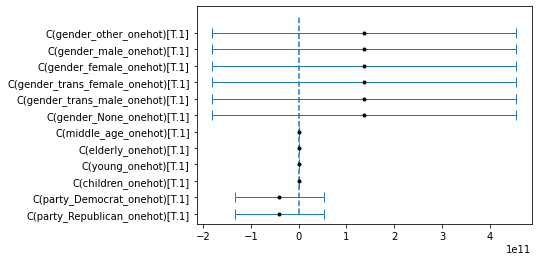

In [194]:
#plot the influence of the different predictors

plt.errorbar(l1, np.array(range(len(l1))), xerr= 2*np.array(l3), linewidth = 1,
             linestyle = 'none',marker = 'o',markersize= 3,
             markerfacecolor = 'black',markeredgecolor = 'black', capsize= 5)

plt.vlines(0,0, len(l1), linestyle = '--')

plt.yticks(range(len(l2)),l2);

## Semantic analysis based on lexical categories
### What are the topics that emerge from our subset of quotes and how do they evolve over time? 

We'll be using Empath to analyze our quotes across lexical categories. The lexical categories we're going to use will be the one's that appear the most for every quote of our 2015-2020 dataset.

### Get the top 20 most frequent categories

In [ ]:
from empath import Empath

In [ ]:
speaker_quotes_semantic = total_df.copy()

In [ ]:
lexicon = Empath()
# list of every possible category
keys = list(lexicon.cats)
categories_count = dict(zip(keys, [0]*len(keys)))

# counts the number of times a topic appears in our subset of quotes
for quote in speaker_quotes_semantic.quotation:
    empath_features = lexicon.analyze(quote, normalize=False)
    categories_count = {cat: categories_count[cat]+1 if empath_features[cat]!=0 else categories_count[cat] for cat in categories_count}
categories_count = {k: v for k, v in sorted(categories_count.items(), key=lambda item: item[1], reverse=True)}

In [ ]:
# select the top 20 categories
top_20_categories = dict(list(categories.items())[0:20])
top_20_categories = list(top_20_categories.keys())

#### Topic evolution over time
Now that we have the most frequent lexical categories for our quotes, we use the top 20 to do semantic analysis on our quotes and plot how they evolve over time.

In [ ]:
def semantic_analysis(row, quote, categories):
    ''' Calculates for one quote of a dataframe, the number of words that belong to a specifc category.'''
    empath_values = list(lexicon.analyze(row[quote], categories = categories, normalize=False).values())
    row[categories] = empath_values
    
    return row

def get_num_of_words(quote):
    ''' Returns the number of words of a quote (punctuation and stop words excluded).'''
    # tokenize
    quote_tokens = nltk.word_tokenize(quote)
    # remove ponctuation
    quote_tokens = [word for word in quote_tokens if word.isalnum()]
    # remove stop words
    quote_tokens = [w for w in quote_tokens if not w.lower() in stop_words]
    nb_words = len(quote_tokens)
    
    return nb_words

def get_category_counts(speaker_quotes_df, categories):
    ''' Returns a dataframe containing the raw word counts for every category of every quote.'''
    
    cols = ['quotation', 'num_words'] + categories
    # create new dataframe with one column per topic
    category_counts = speaker_quotes_df.copy()[['quotation']].reindex(columns=cols)
    
    # for every quote
    for index, row in category_counts.iterrows():
       
        # calculate the number of words that belong to a specific category
        category_counts.loc[index] = semantic_analysis(row, 'quotation', categories)
        # calculate the number of words of a quote
        category_counts.loc[index, 'num_words'] = get_num_of_words(category_counts.loc[index, 'quotation'])
    
    return category_counts

def category_evolution(category_counts_df, groupby_columns_list, categories, percentage_type):
    ''' Returns either the percentage of WORDS that belong to these categories
        or the percentage of QUOTES that belong to these categories for each group specified by groupby_columns_list.'''
    # to get the percentage of WORDS that belong to these categories
    if percentage_type == 'words':
        category_evolution = category_counts_df.copy().groupby(groupby_columns_list)[['num_words'] + categories].sum()
        category_evolution[categories] = category_evolution[categories].div(category_evolution.num_words, axis=0)
        
    # to get the percentage of QUOTES that belong to these categories
    elif percentage_type == 'quotes':
        category_evolution = category_counts_df.copy()
        # create one-hot categories
        for col in categories:
            category_evolution[col] = category_evolution[col].apply(lambda x: 1 if x>0 else 0)
        category_evolution = category_evolution.groupby(groupby_columns_list).apply(lambda x: x[categories].sum()/len(x))
        
    else: 
        raise TypeError(f"percentage_type = {percentage_type} => it must be either 'words' or 'quotes'")
        
    return category_evolution

We are interested in carrying out this analysis for politicians that are either Republicans or Democrats. We are also only selecting the quotes containing the word "police". That way, we'll be able to see what topics are associated with the word "police" to understand how politicians talk about law enforcement over time.

In [ ]:
# speaker-quote dataframe to work on for the semantic analysis
speaker_quote_semantic = total_df.copy()
speaker_quote_semantic = speaker_quote_semantic[speaker_quote_semantic.party.isin(["Republican", "Democrat"])]
speaker_quote_semantic = filter_by_keywords(speaker_quote_semantic, ['police'])

In [ ]:
# get the raw word counts for every category of every quote
category_counts = get_category_counts(speaker_quote_semantic, top_20_categories)

# merge the category word counts with the speaker's attributes
category_counts = speaker_quote_semantic.merge(category_counts[['num_words'] + top_20_categories], left_index=True, right_index=True)


#### Plot the evolution of categories over time

In [ ]:
# get the percentage of WORDS that belong to these categories
words_category_evolution = category_evolution(category_counts, groupby_columns_list=['date'], categories=top_20_categories, percentage_type='words')
# get the percentage of QUOTES that belong to these categories
quotes_category_evolution = category_evolution(category_counts, groupby_columns_list=['date'], categories=top_20_categories, percentage_type='quotes')